# DATA SCIENCE 100: Group 128 Project Report
##### Jiakang Huang, Cameron Seymour, Nav Thukral, Shirley Chen
##### Date: December 6th, 2022
 

## Load the R packages

In [3]:
# Use the library function to load the R packages
library(tidyverse)
library(repr)
library(readxl)
library(cowplot)
library(RColorBrewer)
library(tidymodels)

## Introduction:
Birds are a very diverse class of animals, living in all available climates worldwide and functioning in very different ways. There are many different types of birds including terrestrial birds and flying birds. When studying bird fossils and remains, bird bone characteristics, specifically the length of certain bones, can help identify bird species or types (Bochenski & Bochenski Jun., 1992, p. 123). Terrestrial birds are defined as birds that spend most of their lives on the ground, with their appearances usually characterized by shorter wings and bulkier bodies, making flying more difficult for them (Aerial, Terrestrial, n.d.). Flying birds can be defined as birds that spend most of their lives in the air, with their appearances characterized by streamlined, slender bodies with long wingspans (Aerial, Terrestrial, n.d.). Total wing and leg length will be factored in when determining bird type. We can use total length for our prediction based on Nudd's research in his article Wing-bone Length Allometry in Birds (Nudds, 2007, p. 515).

For this report, our predictive question is: Based on the bone structure of bird skeletons, such as the length of leg bones, and the length of wing bones, can we predict whether a given bird skeleton belonged to a flying bird or a terrestrial bird? 

The dataset we are using is a collection from the [National History Museum of Los Angeles County](https://letsvolunteerla.org/listing-item/natural-history-museum-los-angeles-county/). It features measurements of the length and diameter of the major wing and leg bones from 420 bird skeletons. 

<img src="https://media.giphy.com/media/l0K4du1KDvQ8MRPqg/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/l0K4du1KDvQ8MRPqg/giphy.gif

## Method and Results

<img src="https://s-media-cache-ak0.pinimg.com/564x/cb/cb/41/cbcb41cb2c1db6c32c1e869be2172c3b.jpg" width = "400"/>

Source: https://s-media-cache-ak0.pinimg.com/564x/cb/cb/41/cbcb41cb2c1db6c32c1e869be2172c3b.jpg

#### There are 420 birds contained in this dataset. Each bird is represented by 10 measurements (features):
* Huml: Length of Humerus (mm)
* Humw: Diameter of Humerus (mm)
* Ulnal: Length of Ulna (mm)
* Ulnaw: Diameter of Ulna (mm)
* Feml: Length of Femur (mm)
* Femw: Diameter of Femur (mm)
* Tibl: Length of Tibiotarsus (mm)
* Tibw: Diameter of Tibiotarsus (mm)
* Tarl: Length of Tarsometatarsus (mm)

#### Each bird has a label for its ecological group:
* SW: Swimming Birds
* W: Wading Birds
* T: Terrestrial Birds
* R: Raptors
* P: Scansorial Birds
* SO: Singing Birds

### Read the csv file data from the internet into R
We will conduct our data analysis by classification through the K Nearest Neighbour algorithm. The dataset we choose collects skeleton lengths in different parts of various kinds of birds. Since we will verify whether it is possible to predict whether a bird is a flying bird or not based on its skeletal structure, we need to choose the skeletal that we think can distinguish between an aerial bird and a terrestrial bird as variables.
First, we read the CSV file from the internet into R with the help of the `read.csv` function. There are mainly 5 types of birds in our dataset, by using `mutate` and `filter` functions, we classify these into two categories: Aerial, Terrestrial. (Since "SW" refers to swimming birds, it doesn't belong to any of them, so we did not consider it) Since we will be working with `type` as a categorical statistical variable, we will convert it to a factor using the function `as_factor`. 

In [4]:
# Read the csv file data from internat into R,
bird_data <- read.csv("https://raw.githubusercontent.com/DanielHuangjiakang/Projcet-Group-128-DSCI-100/main/bird%202.csv", header = TRUE) |>
    mutate(type =ifelse(type == "T" | type == "W", "Terrestrial",type)) |>
    mutate(type =ifelse(type == "R" | type == "P" | type == "SO", "Flying",type)) |>
    filter(type == "Terrestrial" |type =="Flying")  |>
    mutate(type = as_factor(type))    

bird_data <- replace(bird_data, is.na(bird_data), TRUE)    
head(bird_data, n = 10)

,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,116,157.00,9.00,192.00,7.02,85.60,6.44,227.00,6.84,175.00,6.77,Terrestrial
2,117,190.00,11.92,225.00,8.55,101.75,7.75,240.00,7.71,175.00,7.00,Terrestrial
3,118,70.01,3.71,76.90,2.88,49.42,3.08,79.56,3.35,52.74,3.02,Terrestrial
4,119,92.93,5.28,110.94,3.87,55.11,4.16,137.00,4.29,96.37,3.79,Terrestrial
5,120,118.52,6.87,134.91,5.06,78.20,5.24,132.00,5.38,85.28,4.74,Terrestrial
6,121,120.26,7.01,132.42,5.40,67.00,5.35,130.10,5.22,87.53,5.12,Terrestrial
7,122,67.63,4.37,60.17,3.73,53.03,4.08,92.18,4.31,54.38,4.14,Terrestrial
8,123,57.08,4.28,46.72,3.63,53.64,4.11,89.93,4.23,58.14,4.32,Terrestrial
9,124,48.19,3.44,43.71,3.01,50.46,3.60,94.86,3.45,55.00,4.57,Terrestrial


The above table shows the first ten observations of our dataset.

##  Forward selection in R

We have decided to focus solely on bone length predictors, omitting bone diameter predictors from this data set, based on the research conducted by Bochenski and Bochenski which states that total wing length is key in the identification of bird species because it affects bird size, skeletal proportions and biology (Bochenski & Bochenski Jun., 1992, p. 130). 

### The method below is from (Data Science A First Introduction Chapter 6.8.3):

In [5]:
set.seed(1234) 
bird_subset <- bird_data |> 
  select(type, huml, humw, ulnal, ulnaw, feml, femw, tibl, tibw, tarl, tarw)
names <- colnames(bird_subset |> select(-type))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# stores selected predictors
selected <- c()

# store the total number of predictors
n_total <- length(names)

# create a 5-fold cross-validation object
bird_vfold <- vfold_cv(bird_subset, v = 5, strata = type)

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("type", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        bird_recipe <- recipe(as.formula(model_string), 
                                data = bird_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(bird_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = bird_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}     

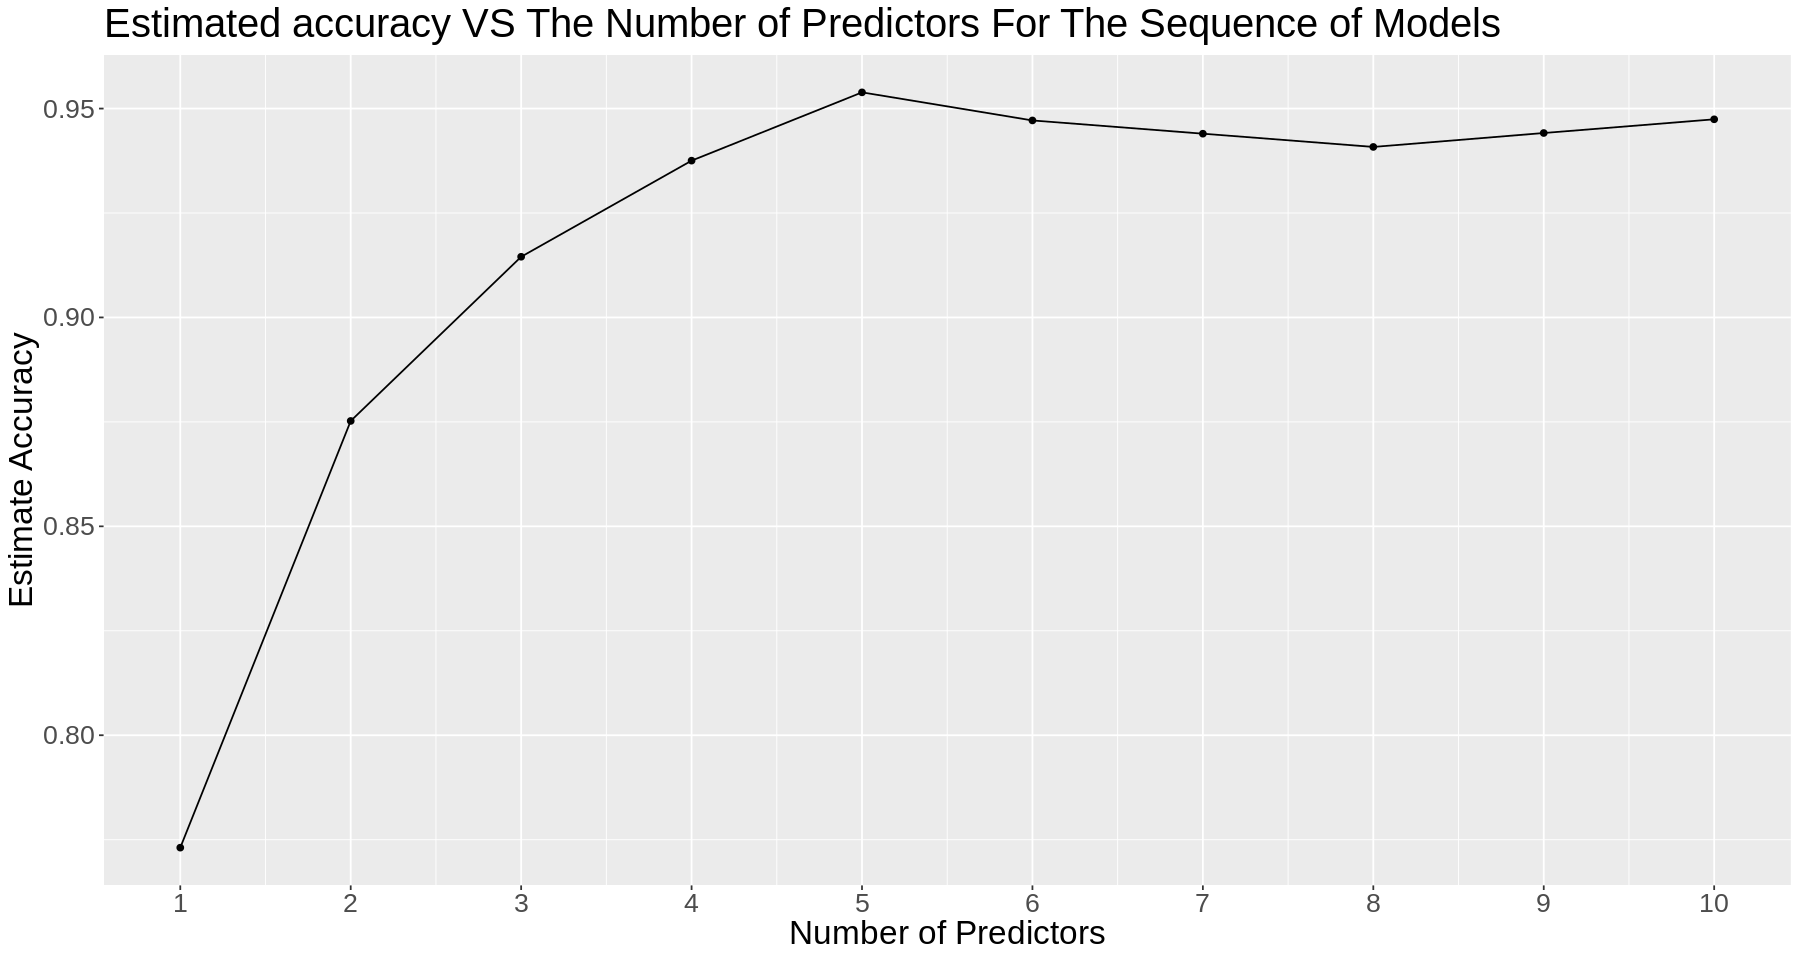

In [8]:
options(repr.plot.width = 15, repr.plot.height = 8)

accuracies_plot <- accuracies |>
    ggplot(aes(x = size, y = accuracy)) +
    geom_line() +
    geom_point() +
    ggtitle("Estimated accuracy VS The Number of Predictors For The Sequence of Models") +
    labs(x = "Number of Predictors", y = "Estimate Accuracy") +
        scale_x_continuous("Number of Predictors", c(1 : 10)) +
     theme(text = element_text(size = 20))

accuracies_plot 

In [9]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,type ~ tibl,0.7730918
2,type ~ tibl+tarl,0.8752265
3,type ~ tibl+tarl+tarw,0.9145249
4,type ~ tibl+tarl+tarw+huml,0.9375322
5,type ~ tibl+tarl+tarw+huml+humw,0.9538745
6,type ~ tibl+tarl+tarw+huml+humw+feml,0.9471532
7,type ~ tibl+tarl+tarw+huml+humw+feml+tibw,0.9439820
8,type ~ tibl+tarl+tarw+huml+humw+feml+tibw+ulnal,0.9408126
9,type ~ tibl+tarl+tarw+huml+humw+feml+tibw+ulnal+femw,0.9441460


The plot above depicts the accuracy estimates for various predictor combinations. The estimated accuracy increases until the `5th` predictor, peaks at that point with approximately `95%` accuracy and then starts decreasing moderately.

In [10]:
best_predictors <- accuracies |>
    arrange(-accuracy) |>
    slice(1)
best_predictors

size,model_string,accuracy
<int>,<chr>,<dbl>
5,type ~ tibl+tarl+tarw+huml+humw,0.9538745


We select all the different lengths of bones from our dataset into predictors. To increase the accuracy of our prediction we use forward selection to choose the best predictors among all the predictors. As shown by the forward selection results, many different combinations of predictors yield accuracies of 93% or above. While we find that the peak estimated accuracy is when we are using tibl, tarl, tarw, huml, humw as predictors, we will choose to use the `tibl, tarl, huml, feml and ulnal` predictors. The rationale for our choice is provided by the Bochenski & Bochenski citation above, and by forward selection results showing high accuracy among various different predictor combinations. 

## Train the classifier

In order to increase the accuracy of our model, we need to provide enough examples for the model to learn appropriately; therefore, a larger training data set should be chosen. We will use `75%` of the data for training, and `25%` for testing. Then we scale and centre only the training data. This ensures that our test data has no effect on our model training. Now, we do `5-fold-cross-validation` using the 5 predictors (`tibl, tarl, huml, feml and ulnal`) to find the best value of k for our nearest neighbour classification. 

In [11]:
set.seed(1234)

# create the 25/75 split of the training data into training and validation
bird_split <- initial_split(bird_data, prop = 0.75, strata = type)
bird_train <- training(bird_split)
bird_test <- testing(bird_split)

# set recipe by 5 predictors
 bird_recipe <- recipe(type ~  feml + huml + tarl + tibl + ulnal , 
                        data = bird_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

# To perform 5-fold cross-validation in R with tidymodels, we use another function: vfold_cv.
bird_vfold <- vfold_cv(bird_train, v = 5, strata = type)

# tuned should be specified as tune() in the model specification rather than given a particular value.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# k_vals data frame with the neighbors variable containing values from 1 to 20, step by 1. Using the seq function.
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

accuracy_k <- workflow() |>
    add_recipe(bird_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = bird_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |> 
    arrange(-mean) 

In [12]:
accuracy_vs_k <- ggplot(accuracy_k, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  ggtitle("Estimated Accuracy VS The Number of Neighbors") +
  theme(text = element_text(size = 20)) +
  scale_x_continuous("Neighbors", c(1 : 20))

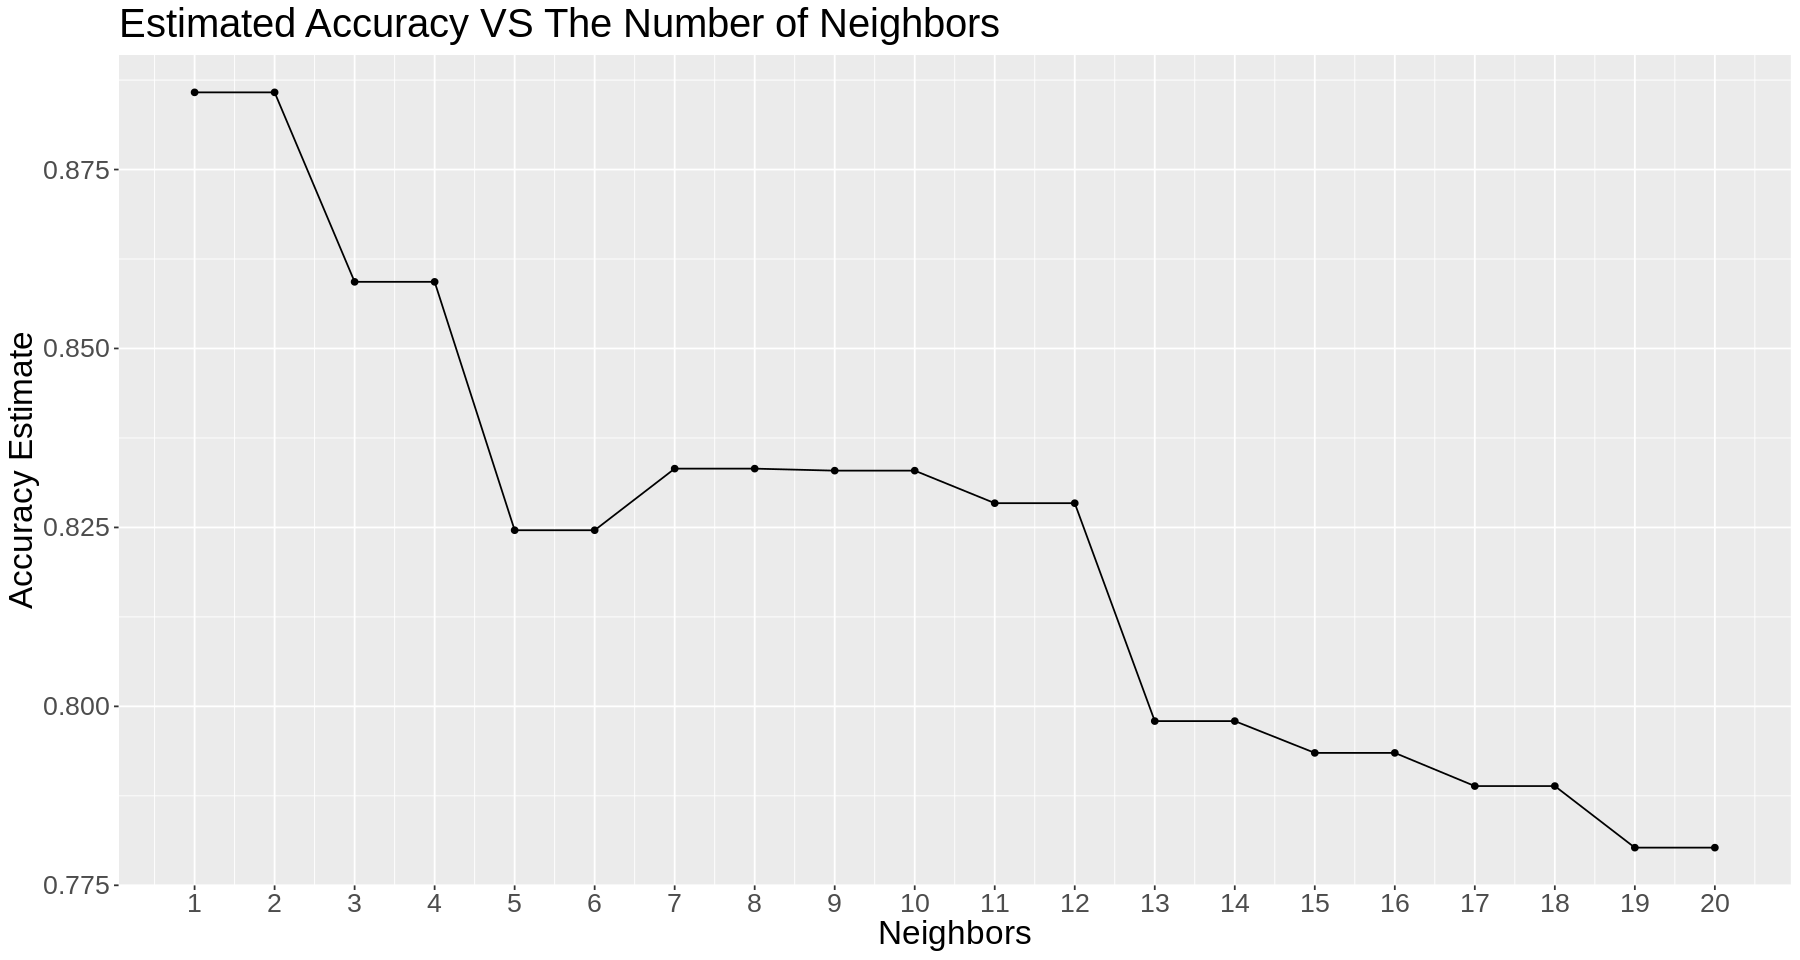

In [13]:
accuracy_vs_k

The above figure visualizes how the number of neighbours K affects the estimated accuracy. 

In [14]:
# find the Top 6 highest mean of the neighbors
head(accuracy_k,6)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8857807,5,0.008646305,Preprocessor1_Model01
2,accuracy,binary,0.8857807,5,0.008646305,Preprocessor1_Model02
3,accuracy,binary,0.8593072,5,0.028758695,Preprocessor1_Model03
4,accuracy,binary,0.8593072,5,0.028758695,Preprocessor1_Model04
7,accuracy,binary,0.8332120,5,0.020512748,Preprocessor1_Model07
8,accuracy,binary,0.8332120,5,0.020512748,Preprocessor1_Model08


The above figure shows the top 6 means and the neighbors they use. And we will not use `k = 1` and `k = 2`. The reason we will not use k=1 is that it will make our model overfitting. And we may want to choose an odd number to avoid ties, so will not choose `k = 2`. Now, we are going to use `k = 3`.

In order to assess how well our model predicts on unknown data, we will retrain our `KNN regression model` for the whole training data set by using the best k that we found above, which is `k = 3`. Then, we will use `predict` and `metrics` functions to calculate the accuracy of our model and use `conf_mat` function to find the confusion matrix.

In [15]:
set.seed(1234)

# Creating spec based on best_K
best_spec <- nearest_neighbor(weight_func = "rectangular" , neighbor = 3) |>
              set_engine("kknn") |>
              set_mode("classification")


# Fit the model
bird_fit <- workflow() |>
    add_recipe(bird_recipe) |>
    add_model(best_spec) |>   
    fit(data = bird_train)

# Predict the testing data with our fitted model
bird_prediction <- predict(bird_fit, bird_test) |>
    bind_cols(bird_test)

# Estimate of the truth and our predictive class
bird_metrics <- bird_prediction |>
    metrics(truth = type , estimate = .pred_class)

bird_conf_mat <- bird_prediction  |>
    conf_mat(truth = type, estimate = .pred_class)
bird_metrics
bird_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8552632
kap,binary,0.6227437


             Truth
Prediction    Terrestrial Flying
  Terrestrial          14      3
  Flying                8     51

The table above shows the accuracy and confusion matrix of our model based on testing data. Our model's accuracy is approximately `85.5%`, indicating that the model looks to generalize kind well to new data that it has never seen before. The confusion matrix shows 14 observations were correctly predicted as terrestrial, and 51 were correctly predicted as flying birds. In addition, for the convenience of description, we assume that the flying bird is the positive side and the terrestrial bird is the negative side. We can determine the `true positive rate`(TPR) is `51/(51+8) = 86.4%`. And `true negative rate`(TNR) is `14/(14+3) = 82.4%`.

## Discussion
### Summary and expectations
Through an analysis of the length of bird wings (based on the total length of the ulna and humerus bones) and the length of bird legs (based on the total length of the tarsus, tibiotarsus and femur bones), our classification model allows us to identify terrestrial and flying birds. Before the creation of our model, we expected to be able to accurately categorize birds as terrestrial or flying birds based on their bone structure. Our findings meet our expected outcome.

By modelling estimated predictor accuracy using forward selection, cross-validation and a K-Nearest-Neighbour model, and through research on journal articles related to bird skeletal structure and fossil research, we identify 5 predictors (huml, ulnal, feml, tibl, tarl), with an approximate accuracy of `94%`, combined with our research findings. Using a K value of 3, which was determined through cross-validation, our model provides us with an `85.5%` accuracy on the testing dataset. 

We used several preprocessing steps, including scaling and centring our predictors, to standardize our data and improve its stability. We used a `25/75` split of the testing and training as is standard when developing a K-Nearest-Neighbour classification model. 

The confusion matrix of our model shows that our model is very accurate when using the testing data, which in turn shows that our model will be accurate with unseen data. Our overall accuracy is `85.5%`, the true positive rate is `86.4%` and the true negative rate is `82.4%`. These percentage values indicate that our model accurately separates flying from terrestrial birds, demonstrating that our expected outcome holds. 

### Impact of our findings
The findings of this study are very helpful for determining bird classification as flying or terrestrial based on bird fossils. The characteristics of bird bones allow scientists and archaeologists to identify different bird classifications when excavating different sites. Understanding the species that are or were present in certain locations allows scientists to understand the past and present characteristics of that area’s habitat. Our group’s model offers a way for scientists to quickly and accurately predict the species or type of bird based on fossil and bone characteristics. 

While our dataset only looks at a limited number of observations, this model can still provide a benchmark for researchers in the future to accurately and easily classify birds by type given their bone structure.

### Future questions related to our study
The results of our study only demonstrate a very limited example of how classification models can be used to study bird bone characteristics when identifying species based on fossils. Limitations of our study include the size of our dataset, which only includes 420 bird fossils, that we are only focusing on the length of 5 bones out of a bird's entire skeleton, and that we are limiting our study of bone characteristics to the length of the wing and leg bones. 

Future studies and models should look at the impact of the ratio between the wing and leg length and bird body mass, as well as other bone characteristics such as diameter or density as these metrics can help to more accurately differentiate between samples. Future models could also consider how the length of each bone, instead of the total length, can be used to help differentiate between different species, offering an extension of our study that classifies birds as flying or terrestrial birds. Different maximum and minimum lengths of individual bones, such as an ulna or humerus bone length, can be compared to the total wing or leg length to determine done positioning, a factor that is unique to different species of birds (Bochenski & Bochenski Jun., 1992, p. 131). 


## Citations
### References:
1. Aerial, terrestrial and arboreal birds. (n.d.). Bird Spot. https://www.birdspot.co.uk/identifying-birds/aerial-terrestrial-and-arboreal-birds
2. Birds' bones and living habits. (n.d.). Kaggle. https://www.kaggle.com/datasets/zhangjuefei/birds-bones-and-living-habits
3. Bochenski, Z., & Bochenski Jun., Z. (1992). Correlation between the wing length of living birds and measurements of their bones. Belgian Journal of Zoology, 122(1), 123-132. https://biblio.naturalsciences.be/associated_publications/bjz/122-1/bjz_122_bochenski_123-132.pdf
4. Nudds, R. L. (2007). Wing-Bone length allometry in birds. Journal of Avian Biology, 38(4), 515-519. https://www.jstor.org/stable/30244826
5. Peng, T. T., Trevor Campbell, and Melissa Lee Foreword by Roger. (n.d.).6.8.3 Forward selection in R | Data Science. In datasciencebook.ca. Retrieved December 7, 2022, from https://datasciencebook.ca/intro.html